In [5]:
from torch import nn
import numpy as np

class TransferFeatures(nn.Module):
    def __init__(self, pretrainedModel, classifier):
        super(TransferFeatures, self).__init__()

        self.features = pretrainedModel.features
        self.classifier = classifier

        # Freeze those weights
        for p in self.features.parameters():
            p.requires_grad = True

    def forward(self, x):
        f = self.features(x)
        # flatten network
        f = f.view(f.size(0), np.prod(f.shape[1:]))
        y = self.classifier(f)
        return y

In [6]:
from PIL import Image
import torch
from torch import nn
from torchvision.transforms import ToTensor
from torchvision import models
from torchvision import datasets
import torch.optim as optim

def transform(img):
    img = img.resize((224, 224)).convert('RGB')
    tensor = ToTensor()(img)
    return tensor

trainSet = datasets.MNIST(
    root = 'data',
    train = True,
    download=True,
    transform = transform,
)

batch = 4
trainLoader = torch.utils.data.DataLoader(trainSet, batch_size=batch, shuffle=True)

classes = (0, 1, 2, 3, 4, 5, 6, 7, 8, 9)

In [7]:
from PIL import Image
import torch
from torch import nn
from torchvision.transforms import ToTensor
from torchvision import models
from torchvision import datasets
import torch.optim as optim


model = models.alexnet(pretrained=True)

classifier = nn.Sequential(
    nn.Dropout(),
    nn.Linear(9216, 4096),
    nn.ReLU(),
    nn.Dropout(),
    nn.Linear(4096, 4096),
    nn.ReLU(),
    nn.Linear(4096, 10),
)

transferedModel = TransferFeatures(model, classifier)

criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(transferedModel.parameters(), lr=0.001, momentum=0.9)

In [8]:
# Trenowanie sieci
noEpochs = 2
prev_epoch = 1
loss_vals=  []
for epoch in range(noEpochs):

    epoch_loss= []
    print("Starting epoch ", epoch + 1)

    for i, data in enumerate(trainLoader, 0):
        # get the inputs; data is a list of [inputs, labels]
        inputs, labels = data

        # zero the parameter gradients
        optimizer.zero_grad()

        # forward + backward + optimize
        outputs = transferedModel(inputs)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        epoch_loss.append(loss.item())
    loss_vals.append(sum(epoch_loss)/len(epoch_loss))

torch.save(transferedModel, 'transferedV4Whole.pth')
print('Finished Training')

Starting epoch  1


c:\Users\creep\AppData\Local\Programs\Python\Python310\lib\site-packages\torch\autograd\__init__.py:173: UserWarning: CUDA initialization: CUDA driver initialization failed, you might not have a CUDA gpu. (Triggered internally at  ..\c10\cuda\CUDAFunctions.cpp:112.)
  Variable._execution_engine.run_backward(  # Calls into the C++ engine to run the backward pass


Starting epoch  2
Finished Training


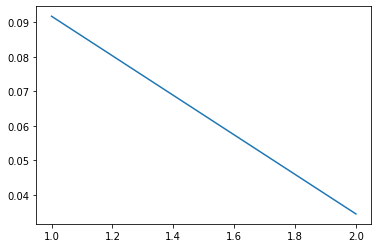

In [9]:
import matplotlib.pyplot as plt

plt.plot(np.linspace(1, noEpochs, noEpochs).astype(int), loss_vals)

In [10]:
def transform(img):
    img = img.resize((224, 224)).convert('RGB')
    tensor = ToTensor()(img)
    return tensor

# Evaluate model
testSet = datasets.MNIST(
    root = 'data',
    train = False,
    transform = transform,
)

batch = 4

testLoader = torch.utils.data.DataLoader(
    testSet,
    batch_size=batch,
    shuffle=True
)

In [11]:
from sklearn.metrics import confusion_matrix, classification_report
import pandas as pd
import torch
from torchvision import datasets
from torchvision.transforms import ToTensor

model = torch.load('transferedV4Whole.pth')

model.eval()
y_trues = []
y_preds = []
torch.multiprocessing.set_sharing_strategy('file_system')

for i, data in enumerate(testLoader, 0):
    inputs, labels = data
    
    y_trues.append(int(labels[0]))
    out = model(inputs)
    # get the most probable label
    _, index = torch.topk(out, 1)
    y_preds.append(int(index[0]))


print(confusion_matrix(y_trues,
                       y_preds))


print(classification_report(y_trues,
                            y_preds))

[[239   0   0   0   0   0   0   0   0   0]
 [  0 286   0   0   0   0   0   0   0   0]
 [  0   0 239   2   0   0   0   2   0   0]
 [  0   0   0 276   0   1   0   0   0   0]
 [  0   0   0   0 254   0   0   0   0   0]
 [  1   0   0   1   0 232   0   0   0   0]
 [  1   1   0   0   0   0 240   0   0   0]
 [  0   0   0   0   0   0   0 241   0   0]
 [  0   0   0   0   0   0   0   0 247   1]
 [  1   0   0   0   1   2   0   1   0 231]]
              precision    recall  f1-score   support

           0       0.99      1.00      0.99       239
           1       1.00      1.00      1.00       286
           2       1.00      0.98      0.99       243
           3       0.99      1.00      0.99       277
           4       1.00      1.00      1.00       254
           5       0.99      0.99      0.99       234
           6       1.00      0.99      1.00       242
           7       0.99      1.00      0.99       241
           8       1.00      1.00      1.00       248
           9       1.00     

In [12]:
# Testowanie modelu
with torch.no_grad():
    correctPredictions = 0
    numberOfSamples = 0
    for i, (samples, labels) in enumerate(testLoader):
        # propagacja
        outputs = model(samples) # [100, 10]
        _, predictions = torch.max(outputs, 1) # [100]
        numberOfSamples += labels.shape[0]
        correctPredictions += (predictions == labels).sum().item()

    # obliczenie skuteczności
    accuracy = 100 * correctPredictions / numberOfSamples
    print('accuracy:', accuracy)

accuracy: 99.4


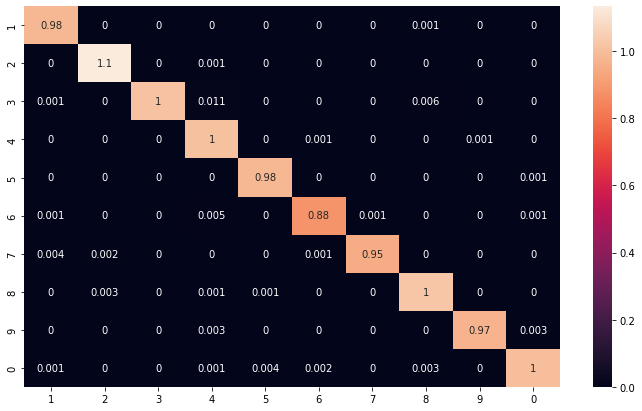

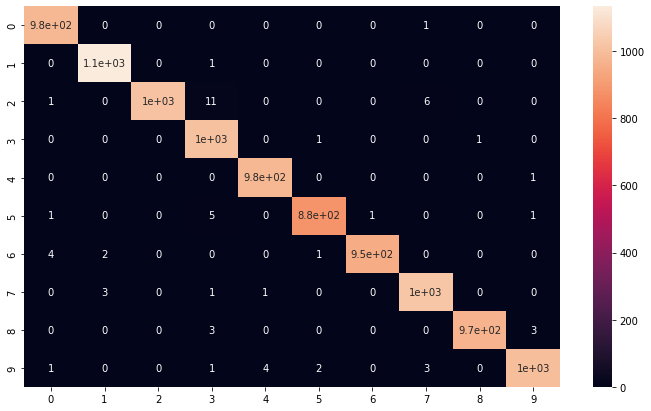

In [13]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pred = []
act = []

for samples, labels in testLoader:

    output = model(samples)

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    pred.extend(output)
        
    labels = labels.data.cpu().numpy()
    act.extend(labels)

classes = ('1', '2', '3', '4', '5', '6', '7', '8', '9', '0')

# Build confusion matrix
cf_matrix = confusion_matrix(act, pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, 
                     index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('DataFrameTrans4.png')
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, annot=True)
plt.savefig('ConfMatrixTrans5.png')

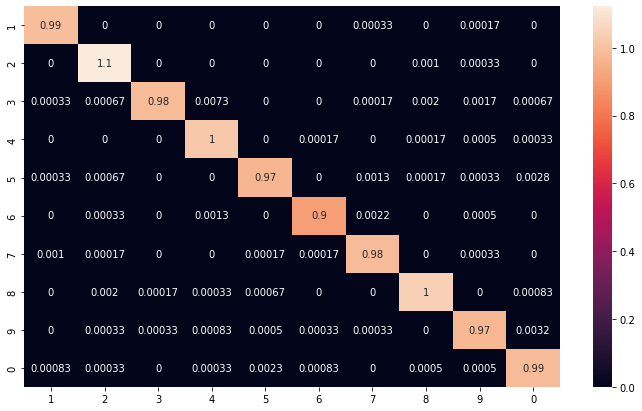

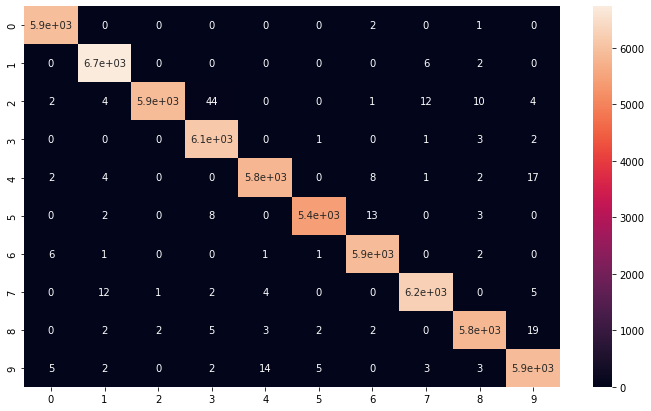

In [14]:
# Confusion Matrix
from sklearn.metrics import confusion_matrix
import seaborn as sn
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

pred = []
act = []

for samples, labels in trainLoader:

    output = model(samples)

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    pred.extend(output)
        
    labels = labels.data.cpu().numpy()
    act.extend(labels)

classes = ('1', '2', '3', '4', '5', '6', '7', '8', '9', '0')

# Build confusion matrix
cf_matrix = confusion_matrix(act, pred)
df_cm = pd.DataFrame(cf_matrix/np.sum(cf_matrix) *10, 
                     index = [i for i in classes],
                     columns = [i for i in classes])
plt.figure(figsize = (12,7))
sn.heatmap(df_cm, annot=True)
plt.savefig('DataFrameTrans6.png')
plt.figure(figsize = (12,7))
sn.heatmap(cf_matrix, annot=True)
plt.savefig('ConfMatrixTrans7.png')

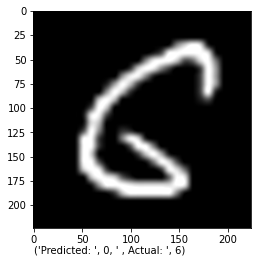

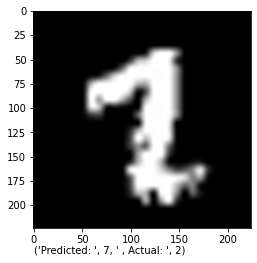

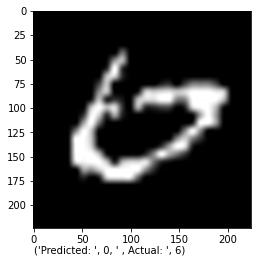

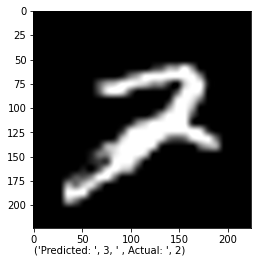

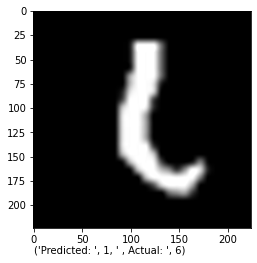

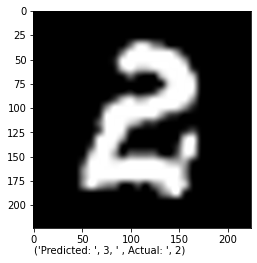

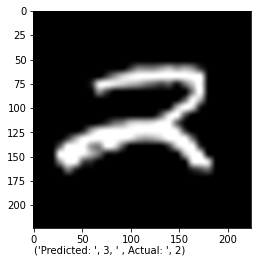

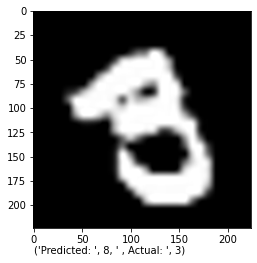

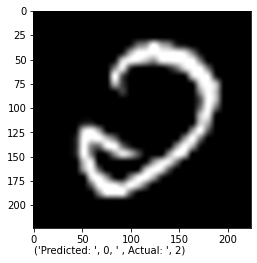

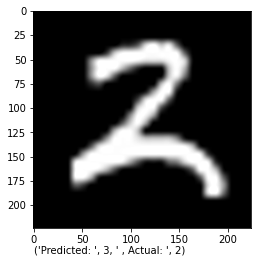

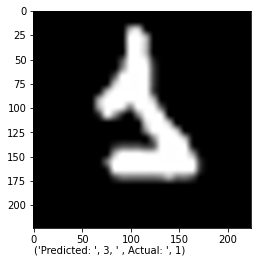

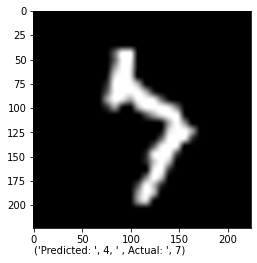

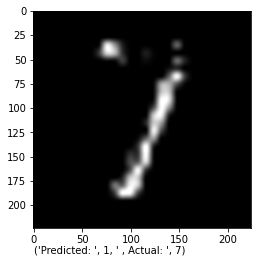

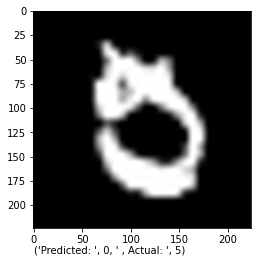

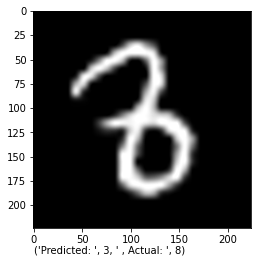

In [39]:
j = 0
# Przykłady złej klasyfikacji
for i, (samples, labels) in enumerate(testLoader):

    output = model(samples)

    output = (torch.max(torch.exp(output), 1)[1]).data.cpu().numpy()
    pred.extend(output)
        
    labels = labels.data.cpu().numpy()
    act.extend(labels)

    if output[j] != labels[j]:
        text = 'Predicted: ', output[j], ' , Actual: ', labels[j]

        img = samples[j][0]

        plt.figure()
        plt.imshow(img, cmap="gray")
        plt.text(0, 250, text)

    j+=1
    if (j >= 4):
        j = 0